In [21]:
# Inspiration: https://gist.github.com/omoindrot/dedc857cdc0e680dfb1be99762990c9c
"""
Download the weights trained on ImageNet for VGG:
```
wget http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz
tar -xvf vgg_16_2016_08_28.tar.gz
rm vgg_16_2016_08_28.tar.gz
```
"""

%matplotlib inline

from matplotlib import pyplot as plt

import argparse
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets


parser = argparse.ArgumentParser()
parser.add_argument('--train_dir', default='coco-animals/train')
parser.add_argument('--val_dir', default='coco-animals/val')
parser.add_argument('--model_path', default='vgg_16.ckpt', type=str)
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--num_workers', default=4, type=int)
parser.add_argument('--num_epochs1', default=10, type=int)
parser.add_argument('--num_epochs2', default=10, type=int)
parser.add_argument('--learning_rate1', default=1e-3, type=float)
parser.add_argument('--learning_rate2', default=1e-5, type=float)
parser.add_argument('--dropout_keep_prob', default=0.5, type=float)
parser.add_argument('--weight_decay', default=5e-4, type=float)

VGG_MEAN = [123.68, 116.78, 103.94]


In [6]:
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm

# read in the data files 
x = []
x_test = []
y = [] # one hot encoding of which of the 17 tags this image is (images can have multiple tags)

df_train = pd.read_csv('data/train_v2.csv') # column1: image_name, column2: tags (labels for image file)

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# for each filename and targets, read in pixel values from file, save image (resized to 32 x 32) to x, labels vector to y
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x.append(cv2.resize(img, (32, 32)))
    y.append(targets)

100%|██████████| 40479/40479 [08:32<00:00, 79.06it/s]


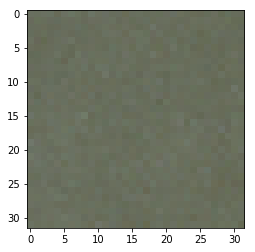

(32, 32, 3)


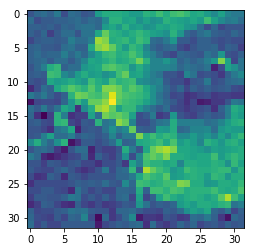

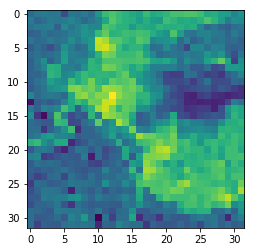

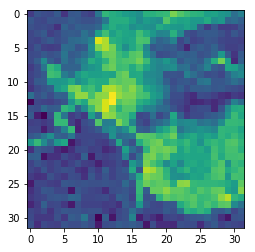

raw_image


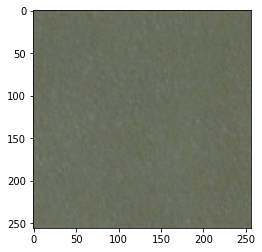

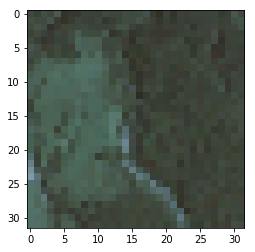

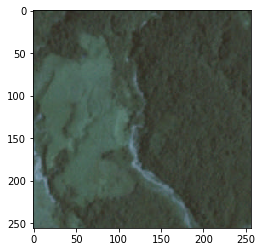

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.] [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.] (17,)


In [45]:
# view some images

plt.imshow(x[0])
plt.show()
#plt.imshow(x[1])
#plt.show()
print(x[1].shape)
plt.imshow(x[10][:, :, 0])
plt.show()
plt.imshow(x[10][:, :, 1])
plt.show()
plt.imshow(x[10][:, :, 2])

plt.show()


print('raw_image')
img_ex = cv2.imread('data/train-jpg/{}.jpg'.format('train_0'))
plt.imshow(img_ex)
plt.show()


plt.imshow(x[1])
plt.show()

img_ex = cv2.imread('data/train-jpg/{}.jpg'.format('train_1'))
plt.imshow(img_ex)
plt.show()

print(y[0], y[1], y[0].shape)
